In [45]:
import os
import os.path as path
import sys  

PARENT_DIR =  path.abspath(path.join('Sentiment_Analysis_SHAP' ,"../../../"))
sys.path.insert(0, PARENT_DIR)

In [46]:
import numpy as np
import shap
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from imdb_data_utils import read_imdb_split,download_data
from sklearn.feature_extraction.text import TfidfVectorizer
from model_helper.PipelineWrapper import PipelineWrapper
from model_helper.predict_and_save import predict_and_save
from model_helper.shap import calculate_and_save
from custom_shap_explainer.custom_global import custom_global_explanation, custom_global_boxplot
from custom_shap_explainer.signal_words import highlight_signal_words
np.random.seed(1337)
shap.initjs()

# 1. Get Training Data 

In [47]:
download_data()
corpus_train, y_train = read_imdb_split('../data/aclImdb/train')
corpus_test, y_test = read_imdb_split('../data/aclImdb/test')


The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


# 2. Build Vectorizer

In [48]:
vectorizer_tf_idf = TfidfVectorizer(min_df=0.001, max_df=0.99)
vectorizer_tf_idf.fit(corpus_train)

TfidfVectorizer(max_df=0.99, min_df=0.001)

# 3. Build Models

# 3.1 Build Logistic Regression Model

In [49]:
model = linear_model.LogisticRegression(penalty="l2")
model_logregression = PipelineWrapper(model, vectorizer_tf_idf, corpus_test, corpus_train, y_test, y_train)

In [50]:
model_logregression.fit()

In [51]:
model_logregression.report()

0             1  accuracy     macro avg  weighted avg
precision      0.885746      0.886735   0.88624      0.886241      0.886241
recall         0.886880      0.885600   0.88624      0.886240      0.886240
f1-score       0.886313      0.886167   0.88624      0.886240      0.886240
support    12500.000000  12500.000000   0.88624  25000.000000  25000.000000

In [52]:
predictions_logreg = model_logregression.predict_proba(corpus_test)


LOGREG_PREDICTION_FILE = 'predictions_logreg.csv'

file_exists = os.path.exists(LOGREG_PREDICTION_FILE)

if not file_exists:
    # Calculate BERT predictions
    
    predict_and_save(model_logregression, 'logreg', corpus_test, LOGREG_PREDICTION_FILE)

# 3.2 Build Decision Tree Classifier

In [53]:
from sklearn.tree import DecisionTreeClassifier


model_dtc = PipelineWrapper(DecisionTreeClassifier(min_samples_leaf=20), vectorizer_tf_idf, corpus_test, corpus_train, y_test, y_train)

In [54]:
model_dtc.fit()

In [55]:
model_dtc.report()

0             1  accuracy     macro avg  weighted avg
precision      0.713115      0.728629    0.7206      0.720872      0.720872
recall         0.738160      0.703040    0.7206      0.720600      0.720600
f1-score       0.725422      0.715606    0.7206      0.720514      0.720514
support    12500.000000  12500.000000    0.7206  25000.000000  25000.000000

In [56]:
predictions_DTC = model_dtc.predict_proba(corpus_test[:1])
predictions_DTC

array([[0.73913043, 0.26086957]])

In [57]:
DTC_PREDICTION_FILE = 'predictions_dtc.csv'

file_exists = os.path.exists(DTC_PREDICTION_FILE)

if not file_exists:
    predict_and_save(model_dtc, 'dtc', corpus_test, DTC_PREDICTION_FILE)

# 3.3 Build Fine Tuned BERT

In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("jowid100/FineTunedBERTSentiment")
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained("jowid100/FineTunedBERTSentiment")
model_bert = pipeline('sentiment-analysis', model=loaded_model, tokenizer=tokenizer, max_length=512, truncation=True, top_k=None) 

In [59]:
model_bert.predict(corpus_test[:5])

[[{'label': 'LABEL_1', 'score': 0.9973391890525818},
  {'label': 'LABEL_0', 'score': 0.0026607937179505825}],
 [{'label': 'LABEL_1', 'score': 0.9945743680000305},
  {'label': 'LABEL_0', 'score': 0.005425640847533941}],
 [{'label': 'LABEL_0', 'score': 0.9939568042755127},
  {'label': 'LABEL_1', 'score': 0.006043117959052324}],
 [{'label': 'LABEL_0', 'score': 0.9993140697479248},
  {'label': 'LABEL_1', 'score': 0.0006858850247226655}],
 [{'label': 'LABEL_0', 'score': 0.9995158910751343},
  {'label': 'LABEL_1', 'score': 0.0004840875626541674}]]

In [60]:
BERT_PREDICTION_FILE = 'prediction_BERT.csv'
file_exists = os.path.exists(BERT_PREDICTION_FILE)

if not file_exists:
    # Calculate BERT predictions
    raw_predictions_bert = model_bert.predict(corpus_test)

    # Destructure probabilities for class_1 and class_2
    predictions_class_0 = [pred[0]['score'] if pred[0]['label'] == 'LABEL_0' else pred[1]['score'] for pred in raw_predictions_bert]
    predictions_class_1 = [pred[0]['score'] if pred[0]['label'] == 'LABEL_1' else pred[1]['score'] for pred in raw_predictions_bert]

    # Create a DataFrame containing the test samples and BERT predictions
    results = pd.DataFrame({
        'bert_0': predictions_class_0,
        'bert_1': predictions_class_1
    })

    # Save the DataFrame to a CSV file
    results.to_csv(BERT_PREDICTION_FILE)


# 4 Analyze With SHAP

We know that the Logistic Regression Performs better than the Decision Tree Classifier.
To further investigate why thats the case we need to look into the models.

In the following i will do 3 things.

Per Model:
1. Most Positive/Negative Words
2. Investigate the Most Wrong Positive and Negative prediction

Model Comparision:
1. Investigate biggest Prediction gap accross the models

# 4.1 Logistic Regression with SHAP

In [61]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer_logreg = shap.Explainer(model_logregression.predict_proba, masker)
shap_values_file = "shap_values_logreg.pkl"

shap_values_logreg = calculate_and_save(shap_values_file, explainer_logreg, corpus_test)


### 4.1 Investigate the biggest misclassification


In [62]:
from model_helper.model_evaluation_utils import get_misclassifications

logreg_misclassifications = get_misclassifications(y_test,LOGREG_PREDICTION_FILE)

In [63]:
logreg_misclassifications[:5]

logreg_0  logreg_1  label      diff  misclassified
8426   0.015421  0.984579      0  0.984579           True
8989   0.016913  0.983087      0  0.983087           True
9634   0.981160  0.018840      1  0.981160           True
18328  0.980439  0.019561      1  0.980439           True
6685   0.021349  0.978651      0  0.978651           True

In [64]:
# Really good example to investigate why the model predicted the wrong class
most_wrong_positive_index  = 9634

#### 4.1.2 Most Wrong Positive Classification

Most wrong review 

In [65]:
print(logreg_misclassifications.loc[most_wrong_positive_index])
print(corpus_test[most_wrong_positive_index])

logreg_0         0.98116
logreg_1         0.01884
label                  1
diff             0.98116
misclassified       True
Name: 9634, dtype: object
when the movie first started i thought cheesy the first ten minutes were really boring after the slow beginning and some of the soap opera antics i started liking it the plot was different than anything i had ever seen now was it a horror not really it should not have been classied as a horror or the producers should have put more money into the movie to make it scary as it was the creatures where only there for a short time i can only assume this was for money reason the good side was that the movie was very entertaining it held my interest after the start and did make me wonder about creatures from another dimension it was obvious that this was a first time movie for the director but there were a couple of highlights by the end i was hooked too bad hollywood did not put more money behind this 


In [66]:
explanation = shap_values_logreg[most_wrong_positive_index, :, 1]

so its 0.5 behind the real label.
But Why lets investigate

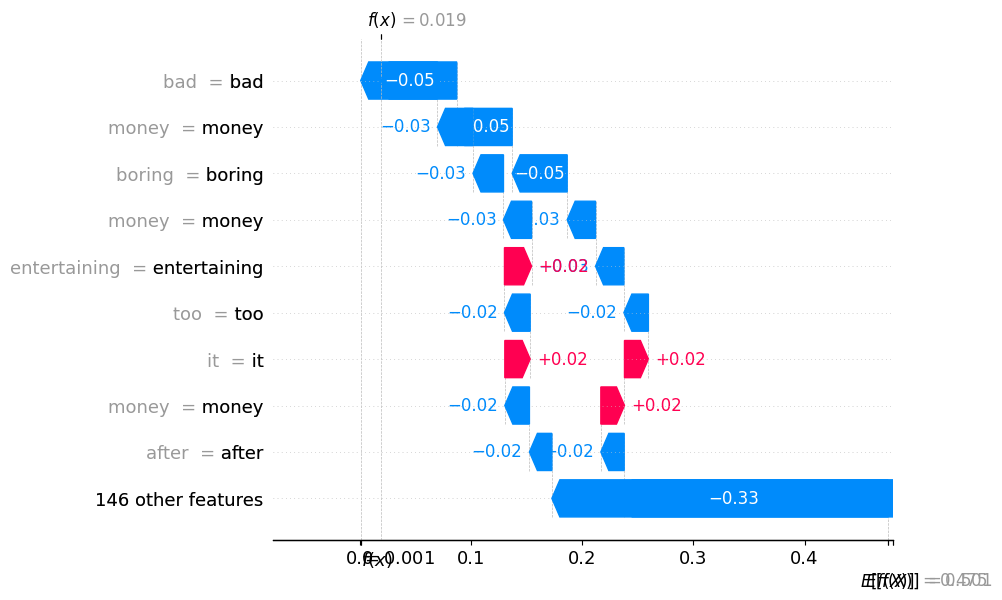

In [67]:
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

In [68]:
# further investigate what words really matter - highlight the words that contributed most to the prediction

highlight_signal_words(explanation,round_shap_values=3,top_words=4)

# interpretation:

The model learned that the word bad and boring are negative sentiment words and they overlap all other words you can see that the review is really positive beacuse of this passage:
`after the slow beginning and some of the soap opera antics i started liking it the plot was different than anything i had ever seen now`.

So it wasnt able to understand that the word liking is really important for the sentiment.

With the highlight Plot we can really see that it doesnt pay relevant attention to the relevant part.

#### 4.1.2 Most Wrong Negative Classification

Most wrong review 

In [69]:
most_wrong_negative_index  = 8426
explanation = shap_values_logreg[most_wrong_negative_index, :, 1]

In [70]:
print(logreg_misclassifications.loc[most_wrong_negative_index])
print(corpus_test[most_wrong_negative_index])

logreg_0         0.015421
logreg_1         0.984579
label                   0
diff             0.984579
misclassified        True
Name: 8426, dtype: object
this movie was pure genius john waters is brilliant it is hilarious and i am not sick of it even after seeing it about 20 times since i bought it a few months ago the acting is great although ricki lake could have been better and johnny depp is magnificent he is such a beautiful man and a very talented actor and seeing most of johnny s movies this is probably my favorite i give it 9 5 10 rent it today 


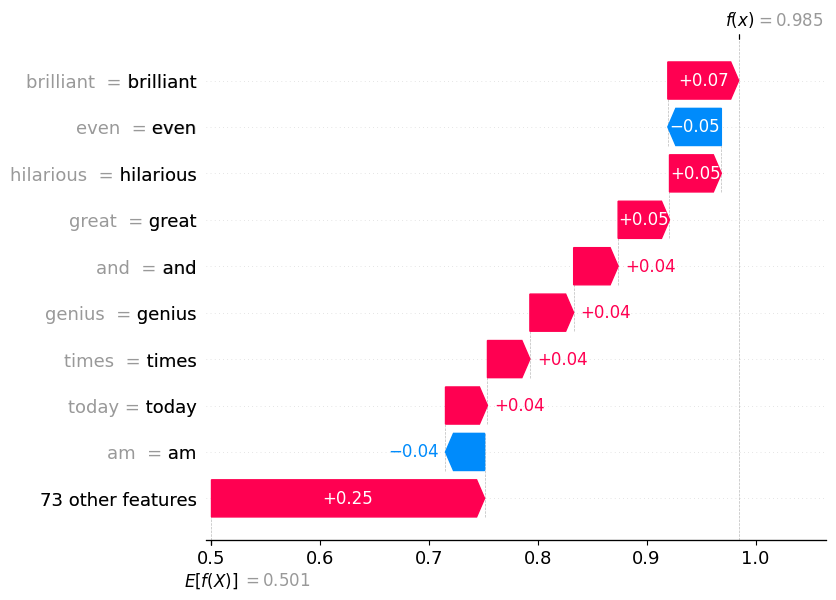

In [71]:
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

In [72]:
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

# Interpretation:

This was a correct classification but the initial label is wrong?
So we found a mistake in the labeled training data.
With this information we can remove the sample and further improve the training process


# 4.2 Global Interpretation Most Positive and negative Words

To understand how the model works

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


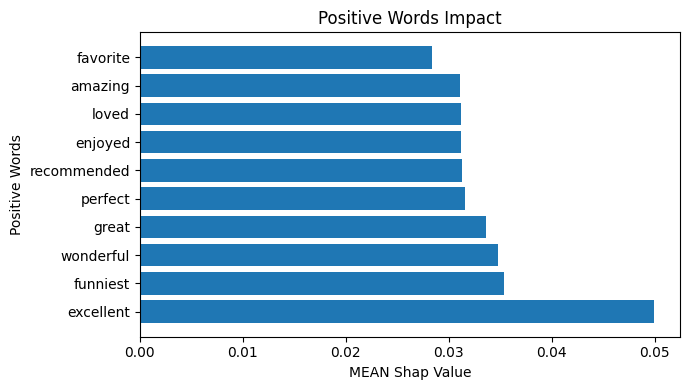

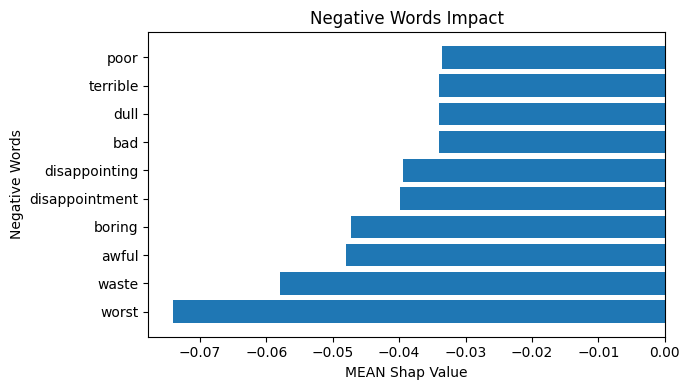

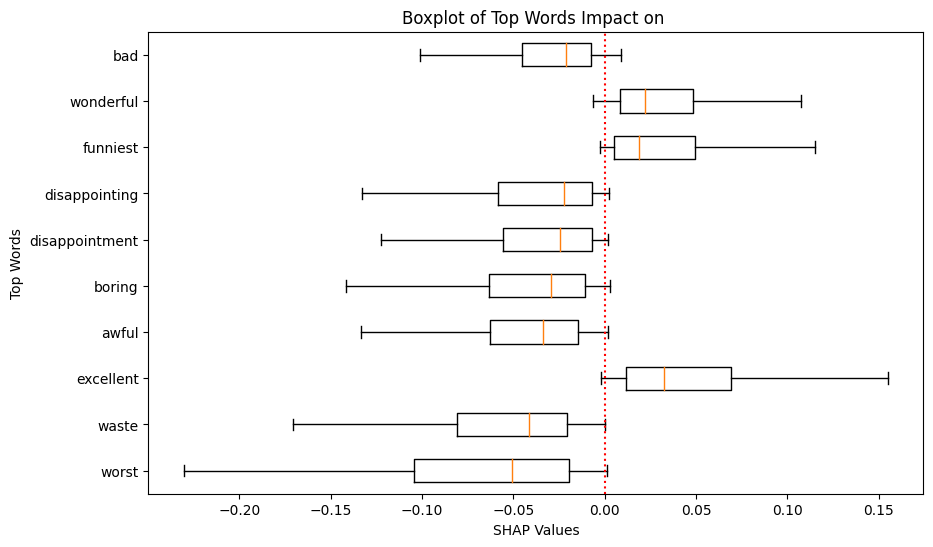

In [73]:
custom_global_explanation(shap_values_logreg[:,:,1])
custom_global_boxplot(shap_values_logreg[:,:,1])

# interpretation:

It seems like the model learned the correct words

# 5. Analyze with SHAP: DTC

In [74]:
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
explainer_dtc = shap.Explainer(model_dtc.predict_proba, masker)
shap_values_file = "shap_values_dtc.pkl"

shap_values_dtc = calculate_and_save(shap_values_file, explainer_dtc, corpus_test)

# 5.1 Investigate Biggest Misclasssifications

In [75]:
dtc_misclassifications = get_misclassifications(y_test, DTC_PREDICTION_FILE)

In [76]:
dtc_misclassifications[:5]


dtc_0  dtc_1  label  diff  misclassified
12432    0.0    1.0      0   1.0           True
18794    0.0    1.0      0   1.0           True
18831    0.0    1.0      0   1.0           True
6737     0.0    1.0      0   1.0           True
6725     0.0    1.0      0   1.0           True

In [77]:
most_wrong_positive_index = 11617

### 5.2.1 Most Wrong Positive Classification

In [78]:
explanation = shap_values_dtc[most_wrong_positive_index, :, 1]
print(dtc_misclassifications.loc[most_wrong_positive_index])
print(corpus_test[most_wrong_positive_index])

dtc_0             1.0
dtc_1             0.0
label               1
diff              1.0
misclassified    True
Name: 11617, dtype: object
this is one peace of art if you like comedy you should watch this here comes a funny moment from the movie spoiler nikolai and goroshkov are walking together in paris for the first time they are visiting the local market and goroshkov goes look nikolai how much food they have look one two three ten thirty fifty hundred kinds of meat but if ask for a tiny tiny peace just for the taste they will not give you french are very greedy then goroshkov takes nikolai to a tv shop goroshkov tell me who needs all these televisions look at this monster here for example goroshkov points a finger at the monster tv and goes and this motherfu ker he is supposed to be digging a ditch but no he is on tv wait a minute that is me hahah want to laugh watch the movie you will not regret 


In [79]:
model_dtc.predict_proba([corpus_test[most_wrong_positive_index]])

array([[1., 0.]])

0.9


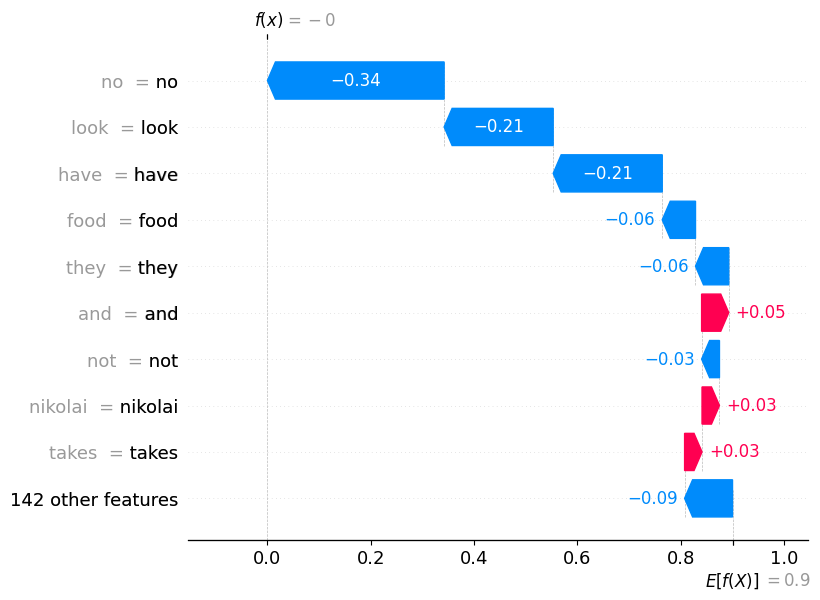

In [80]:
print(explanation.base_values)
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

In [81]:
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

### interpretation

if you read it you know This is a positive Review. 
This Classifier Fails to understand that the review is talking about the scene and not about the movie
you can clearly see the dominating words food they have look are all understand as negative words have great impact on the result with Shap values up to -0.2

### 5.2.2 Most Wrong Negative Classification

In [82]:
most_wrong_negative_index = 11488
explanation = shap_values_dtc[most_wrong_negative_index, :, 1]
print(dtc_misclassifications.loc[most_wrong_negative_index])
print(corpus_test[most_wrong_negative_index])



dtc_0             0.0
dtc_1             1.0
label               0
diff              1.0
misclassified    True
Name: 11488, dtype: object
it seems to be a common thing in the 90 s to play with cliches some manage to do so with great talent hervé hadmar does not on the paper the movie looked interesting though the weak plot could have been saved by great moments of comedy dark humour and a very décalé style director hadmar unfortunately kills his direction with his camera angles and his absolute lack of rhythm every joke is embarassing as no one reacts in the theater the movie is incredibly slow and the actors seem to be wondering what the hell they are doing in this ridiculous mascarade what could have been a stylish funny mindless comedy ends up being a cathedral of boredom 


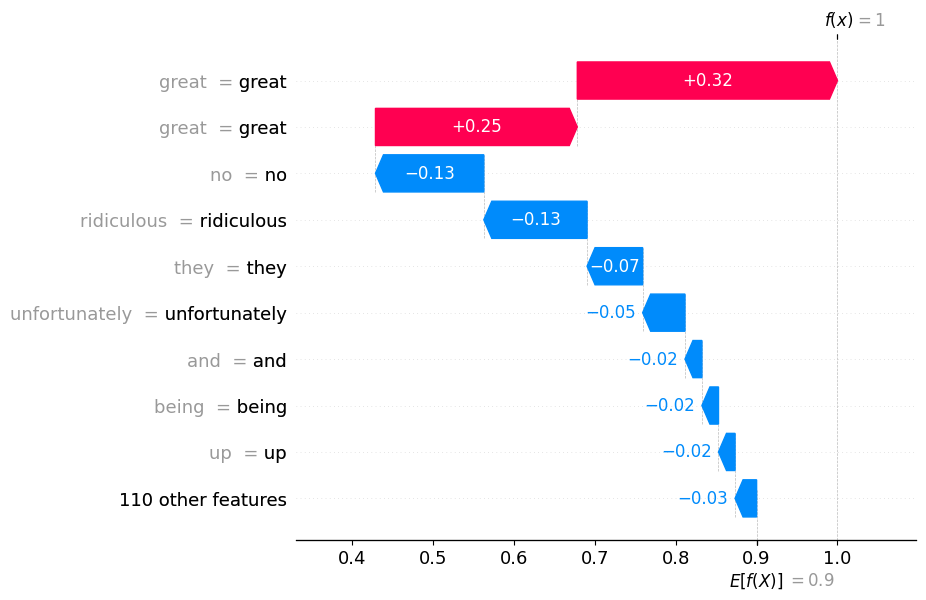

In [83]:
shap.plots.text(explanation)
shap.plots.waterfall(explanation)
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

#### Interpretation 

This is clearly a negative review this person hates the movie.
What confused the model was the use of great it was used in respect of the talent of the actor and what could have saved the movie: "great momments of comedy dark humour".
But both uses of great wasnt about the movie.

# 5.3 Global Explanation

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Glyph 150 (\x96) missing from current font.
Glyph 150 (\x96) missing from current font.


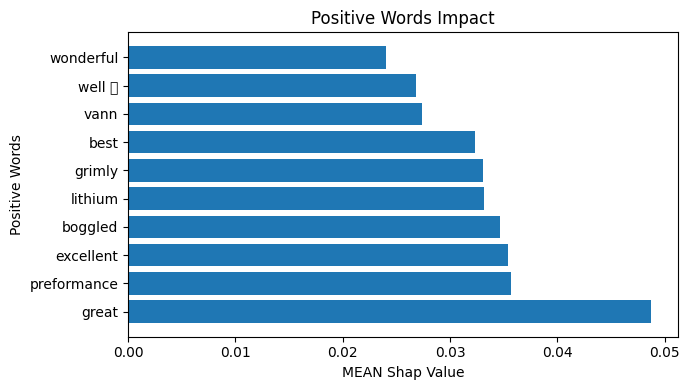

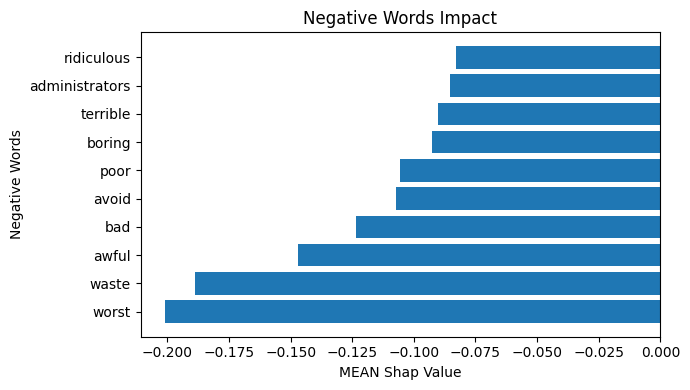

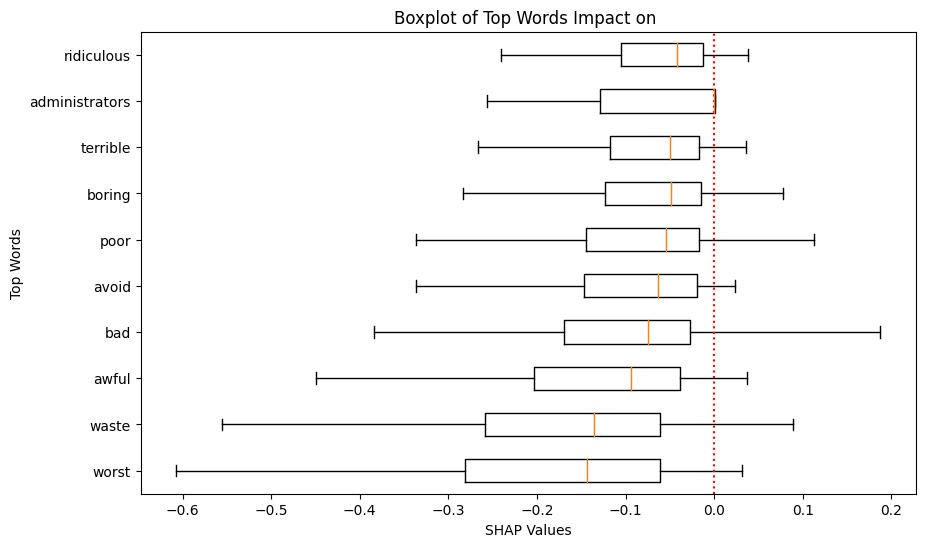

In [84]:

custom_global_explanation(shap_values_dtc[:,:,1])
custom_global_boxplot(shap_values_dtc[:,:,1])


#### interpretation:

you can directly see the Shap values Words with a Positive impact in the 1 percentile are very low and many words. you can directly see that the negative words only 4 lead the sentiment so mess even worse and crap this is great

# 6 SHAP for BERT

In [85]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer_bert = shap.Explainer(model_bert, masker)
shap_values_file = "shap_values_bert.pkl"

shap_values_bert = calculate_and_save(shap_values_file, explainer_bert, corpus_test[:100])

# 6.1 Investigate Biggest Misclassifications



In [86]:
bert_misclassifications = get_misclassifications(y_test, BERT_PREDICTION_FILE)
bert_misclassifications[:10]

bert_0    bert_1  label      diff  misclassified
19396  0.999469  0.000531      1  0.999469           True
22638  0.999456  0.000544      1  0.999456           True
12843  0.999410  0.000590      1  0.999410           True
23047  0.999383  0.000617      1  0.999383           True
3556   0.000622  0.999378      0  0.999378           True
3893   0.999377  0.000623      1  0.999377           True
18639  0.000631  0.999368      0  0.999368           True
19614  0.999361  0.000639      1  0.999361           True
22417  0.999358  0.000642      1  0.999358           True
18923  0.999354  0.000646      1  0.999354           True

### 6.1.2 Biggest Positive Misclassification

In [87]:
most_wrong_positive_index = 19396

explanation = explainer_bert([corpus_test[most_wrong_positive_index]])
explanation = explanation[0, :, 1]

Partition explainer: 2it [00:11, 11.62s/it]               


bert_0           0.999469
bert_1           0.000531
label                   1
diff             0.999469
misclassified        True
Name: 19396, dtype: object
this was laurel and hardy s last silent film for roach studios however since the public had a real thirst for talkies this same short was re made by the team just a few years later with only a few small plot changes laughing gravy was essentially the same plot except that stan and ollie were trying to hide a cute puppy from their grouchy landlord not a goat like in angora love this whole goat angle is the worst part of the film while you could understand the boys wanting to keep a cute little dog after all it is snowy outside why exactly they bring a goat home is just contrived and pointless according to the plot the goat followed them home and so they got tired of shooing it away and kept it huh this just does not make any sense if it had been a giraffe or a cow would they have done the same thing apart from being an unconvincing 

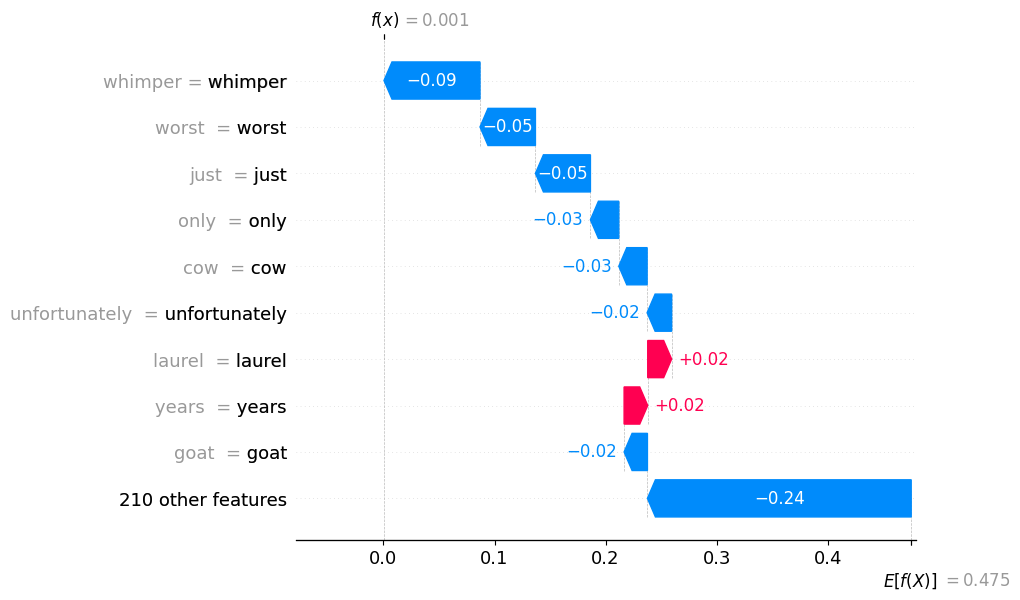

In [88]:
print(bert_misclassifications.loc[most_wrong_positive_index])
print(corpus_test[most_wrong_positive_index])
shap.plots.text(explanation)
shap.plots.waterfall(explanation)


In [89]:
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

#### Interpretration

This Classification was correct the overall sentiment of the review is negative.
But it sounds like this was a disappointed fan who is disappointed how the last laurel and hardy movie ended.
Nevertheless its resulted in a review with a score of > 7.
This could be fixed in the original dataset.



### 6.1.2 Biggest Negative Misclassification 

In [90]:
most_wrong_negative_index = 3556

explanation = explainer_bert([corpus_test[most_wrong_negative_index]])
explanation = explanation[0, :, 1]

Partition explainer: 2it [00:11, 11.85s/it]               


bert_0           0.000622
bert_1           0.999378
label                   0
diff             0.999378
misclassified        True
Name: 3556, dtype: object
lois weber s film hypocrites was and still kind of is a very bold and daring film i enjoyed it and was very impressed by the filming and story of it the priest sees the hypocrisy of the people in his church and tries to show them the naked truth the people are appalled when he reveals the naked statue portraying truth after failing to lead them to it and the few that did help along the way the people do not want to face the truth that they are doing anything wrong but it shows them putting things before god going to beach parties acting inappropriate their materialistic ways and other things in which the people of our world do that tend to not be morally right in the end failing to gain any followers he must enter into the gates of heaven alone this film seems to me to be very bold in the fact that a naked woman is shown throughout 

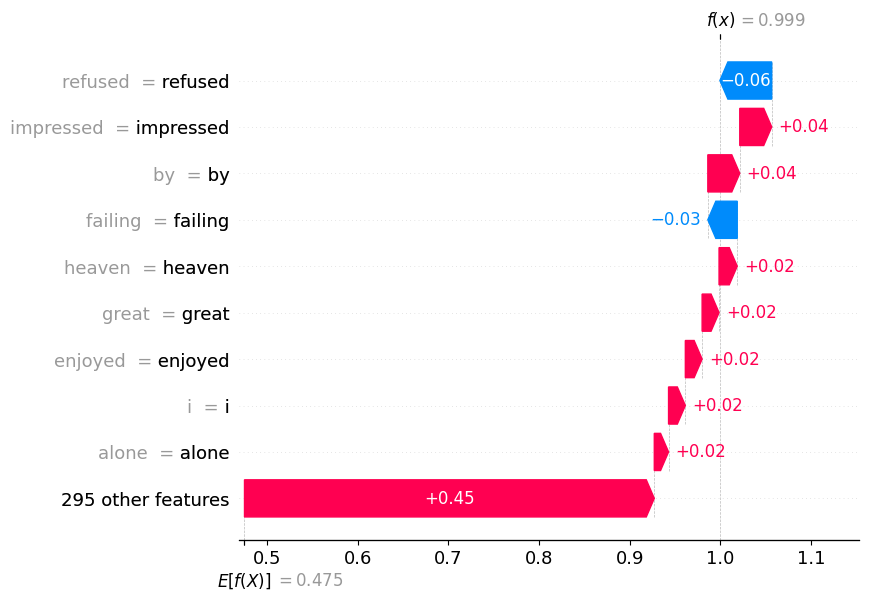

In [91]:
print(bert_misclassifications.loc[most_wrong_negative_index])
print(corpus_test[most_wrong_negative_index])
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

In [92]:
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

#### Interpretation

Man sieht klar das die wörter mit Positiven Sentiment einen Grossen einfuss auf das Review haben:
enjoyed, impressed, incredible, great.
und das das Review auch eindeutig Positiv ist

Jedoch ist es trotzdem Fehlclassifikation nach weiterer Rechereche findet man das original review unter <a href="https://www.imdb.com/review/rw2198364/?ref_=tt_urv">REVIEW</a>.
Und es wurde eindeutig die Falsche anzahl an sternen vergeben

# 6.2 Global Explanation

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


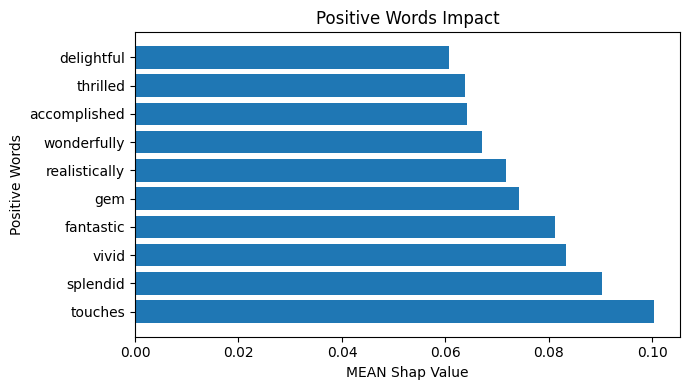

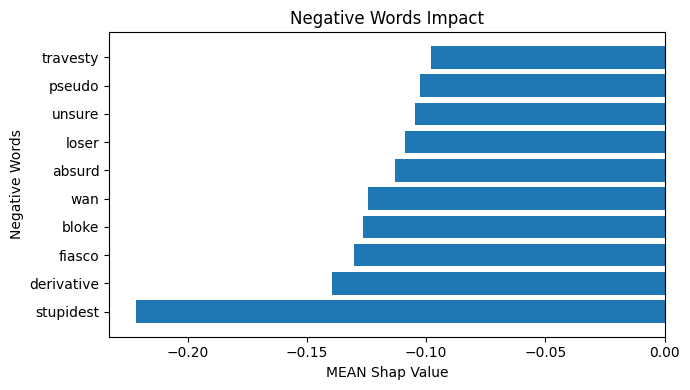

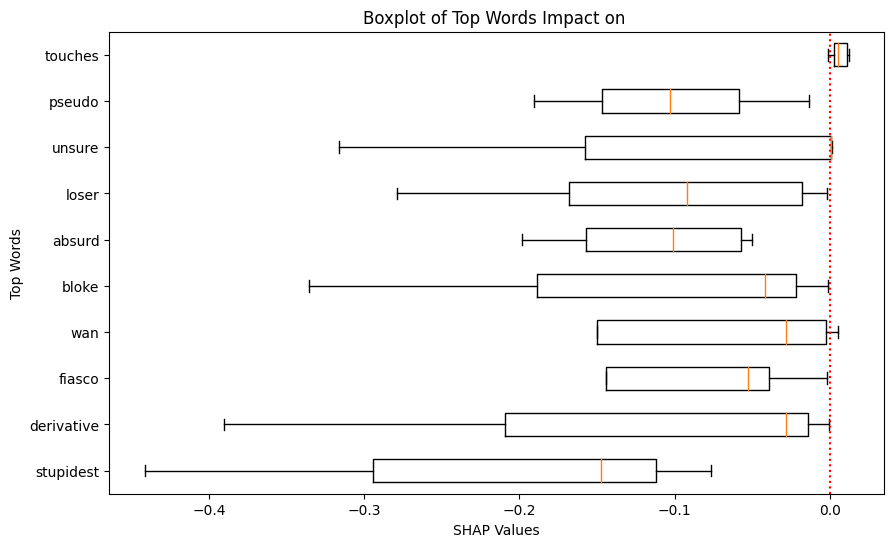

In [93]:
custom_global_explanation(shap_values_bert[:,:,1])
custom_global_boxplot(shap_values_bert[:,:,1])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


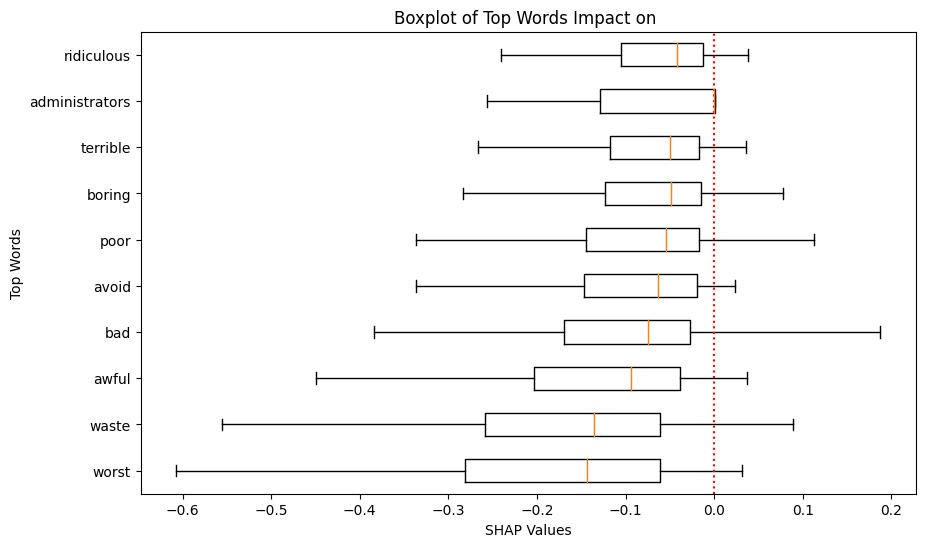

In [94]:
custom_global_boxplot(shap_values_dtc[:,:,1])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


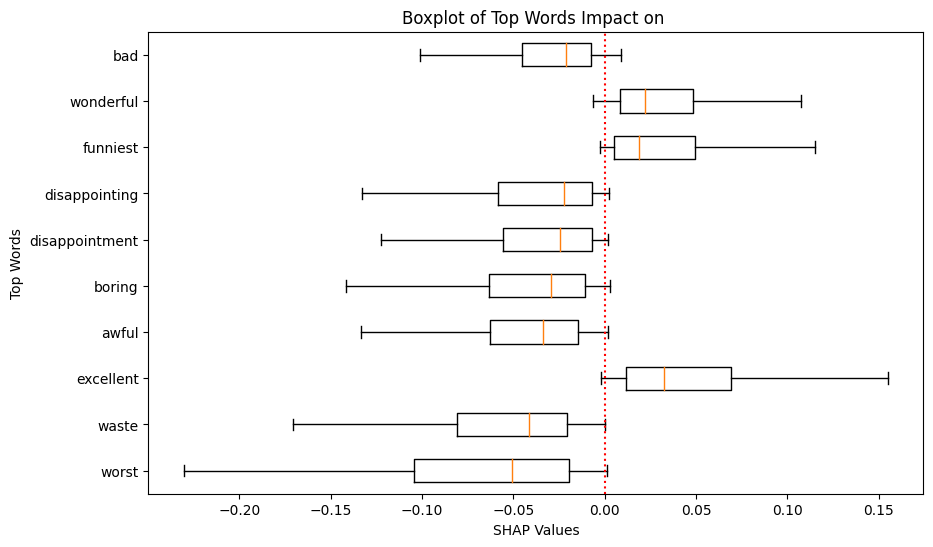

In [95]:
custom_global_boxplot(shap_values_logreg[:,:,1])

# 7 Model Comparision

In [96]:
from model_helper.model_evaluation_utils import get_disagreements


dtc_bert_sorted_by_diff,logreg_bert_sorted_by_diff,logreg_dtc_sorted_by_diff = get_disagreements(y_test,BERT_PREDICTION_FILE, LOGREG_PREDICTION_FILE, DTC_PREDICTION_FILE)

## DTC vs BERT

In [97]:
dtc_bert_sorted_by_diff.head(5)

bert_0    bert_1  logreg_0  logreg_1  dtc_0  dtc_1  label  \
11488  0.999520  0.000480  0.981925  0.018075    0.0    1.0      0   
1356   0.999511  0.000489  0.933107  0.066893    0.0    1.0      0   
16722  0.999500  0.000500  0.959625  0.040375    0.0    1.0      0   
1221   0.999491  0.000509  0.452192  0.547808    0.0    1.0      0   
3055   0.999489  0.000511  0.769727  0.230273    0.0    1.0      0   

       logreg_dtc_diff  logreg_bert_diff  dtc_bert_diff  
11488         0.981925          0.017595       0.999520  
1356          0.933107          0.066405       0.999511  
16722         0.959625          0.039875       0.999500  
1221          0.452192          0.547299       0.999491  
3055          0.769727          0.229762       0.999489

## logreg vs BERT

In [98]:
logreg_bert_sorted_by_diff.head(5)

bert_0    bert_1  logreg_0  logreg_1     dtc_0     dtc_1  label  \
7153   0.004288  0.995712  0.943614  0.056386  0.541667  0.458333      1   
16340  0.998061  0.001939  0.058830  0.941170  0.523810  0.476190      1   
9634   0.047879  0.952121  0.981160  0.018840  1.000000  0.000000      1   
20880  0.035587  0.964413  0.960892  0.039108  1.000000  0.000000      0   
3836   0.998744  0.001256  0.074979  0.925021  0.952381  0.047619      0   

       logreg_dtc_diff  logreg_bert_diff  dtc_bert_diff  
7153          0.401947          0.939326       0.537378  
16340         0.464979          0.939231       0.474251  
9634          0.018840          0.933281       0.952121  
20880         0.039108          0.925305       0.964413  
3836          0.877402          0.923765       0.046363

In [99]:
bert_dtc_log_reg_biggest_difference_index = 7153

In [100]:
corpus_test[bert_dtc_log_reg_biggest_difference_index]

' meet sherri for an evening of pleasure and terror cheap special effects cheesy lines yep its the original 1978 movie nurse sherri starting geoffrey land as peter desmond and jill jacobson as sherri martin and directed by al adamson the movie is about an evil ancient spirit that possesses a nurse at a hospital then she starts killing doctors one by one the acting was okay but some of the acting was robotic the storyline was good but the sex scenes were just thrown in there probably to get more views the directing was bad and the special effects looked like a drawing the effects did not fool anybody the death scenes were pretty good but the director mixed too many things in there that did not make any sense like the sex scenes the nudity the football player and many more overall its a good movie but not the best 7 out of 10'

In [101]:
dtc_explanation = explainer_dtc([corpus_test[bert_dtc_log_reg_biggest_difference_index]])
logreg_explanation = explainer_logreg([corpus_test[bert_dtc_log_reg_biggest_difference_index]])

In [102]:
print('DTC Explanation')
highlight_signal_words(dtc_explanation[0,:,1],round_shap_values=3,top_words=4)
shap.plots.text(dtc_explanation[0,:,1])

DTC Explanation


In [103]:
print('logreg Explanation')
highlight_signal_words(logreg_explanation[0,:,1],round_shap_values=3,top_words=4)
shap.plots.text(logreg_explanation[0,:,1])

logreg Explanation


In [104]:
bert_explanation = explainer_bert([corpus_test[bert_dtc_log_reg_biggest_difference_index]])


Partition explainer: 2it [00:15, 15.66s/it]               


In [105]:
bert_explanation = bert_explanation[0, :, 1]

BERT Explanation


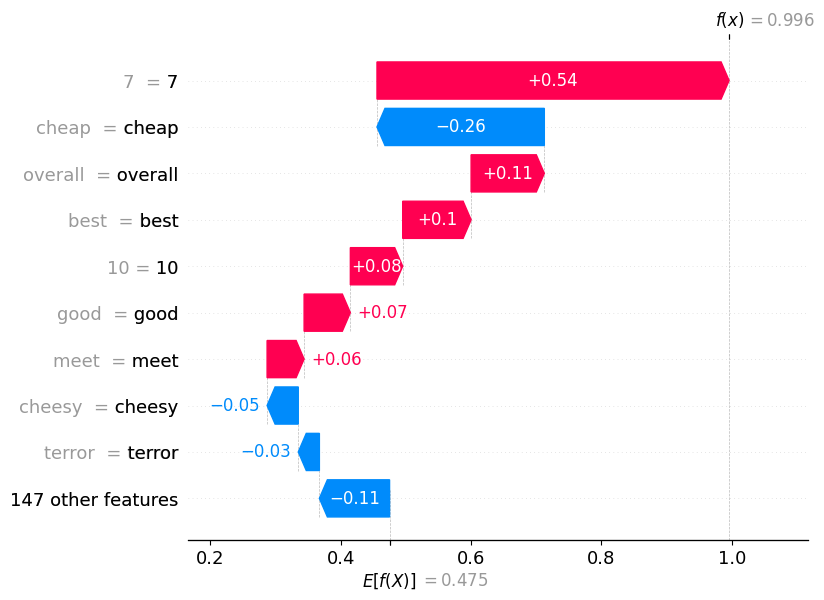

In [106]:
print('BERT Explanation')
highlight_signal_words(bert_explanation,round_shap_values=3,top_words=4)
shap.plots.text(bert_explanation)
shap.plots.waterfall( bert_explanation)

## interpretation:

The Worst Classification was Logistic Regression lets investigate:
Again an example were there reviewer is talking about the movie content and this is interpreted as Negative sentiment.
The model is not contributing anough focus on the last line overal its a good movie.

The second Worst Classification was Decision Tree Classifier lets investigate:
here its more like a 50/50 Decision the model cant really decide if its negative or positive
the most important positive word was "best" and most important negative "Directing was bad"

The best Classification was BERT:
the biggest focus was on 7 so it understand as soon a 7 is present its like 7/10 so its a positive review.
altough it was cheap (score: -0.26) shap understand the the reviewer thinks its overall a good movie


